In [1]:
import pandas as pd
from tqdm import tqdm, trange
import networkx as nx
import numpy as np
# from molvs import standardize_smiles


tqdm.pandas()

df = pd.read_csv('data/uspto-full/2001_Sep2016_USPTOapplications_smiles.rsmi',
                 delimiter='\t',  usecols=['ReactionSmiles'])
df = pd.Series(df.ReactionSmiles.unique())
df = df.sample(100000, random_state = 3) # get a subset of reactions
df = df.str.split('|', expand=True)[0]
# with open('version.smi', 'r') as f:
#     f.readline()
#     smiles = {}
#     for line in tqdm(f):
#         l = line.split(' ')[0].split('.')
#         smiles.update(dict(zip(l, [None]* len(l))))
# purchasable = list(smiles.keys())
print(df.size)

100000


I ran into some issues with matching smiles in the uspto dataset to smiles in the emolecules dataset of purchasable molecules. For simplicity, let's just assume all molecules that cannot be produced by a reaction in this dataset are  with outdegree 0 are purchasable

In [2]:
# split reaction smiles into reactants, agens and products and get individual reactants
r = df.str.split('>', expand=True).rename(columns={0:'reactants',1:'agents',2:'products'})
r = pd.concat({'reactants': r.reactants.str.split('.', expand=True),
               'agents': r.agents.str.split('.', expand=True),
               'products': r.products.str.split('.', expand=True)}, 
              names = ['part'], axis=1)
# identify all unique molecules in the network
molecules = pd.Series(r.stack().stack().unique())

In [3]:
# construct the reaction network as a directed graph
g = nx.DiGraph()
for i in tqdm(r.index): 
    g.add_node(i, typ = 'rxn')
for m in tqdm(molecules):
    g.add_node(m, typ = 'mol')
def add_edge(i):
    reacts = i[['reactants', 'agents']].dropna().values
    reacts = reacts[reacts!=''].tolist()
    g.add_edges_from(list(zip( reacts, [i.name]*len(reacts))))
    prods = i['products'].dropna()
    prods = prods.loc[~prods.isin(reacts)].values.tolist() 
    g.add_edges_from(list(zip( [i.name]*len(reacts), prods)))
r.progress_apply(add_edge, axis=1);

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:59<00:00, 1680.47it/s]


In [4]:
# get the target nodes
def get_synthesis_route(gr, mol, rxns = [], max_depth = None, log = False):
    """
    recursively defined function to get maximum length of the 
    shortest synthesis route for a given molecule as well as the
    corresponding reactions
    
    Args:
    -----
    gr: nx.DiGraph
        reaction network
    mol: str
        target molecule. should be a node in gr
    rxns: list
        list of  reactions that have been encountered up until this point
    max_depth: int
        maximum allowable synthesis route depth
    log: bool
        whether or not to log progress
    """
    
    if max_depth is not None:
        if len(rxns)>max_depth:
            if log:
                print(f"max reached for {rxns}", flush = True)
            return None, None
    
    rxn_depths = {} 
    child_rxns = {}
    longest_routes = {}
    # loop over all reactions that produce this molecule
    for rxn in gr.predecessors(mol): 
        if rxn not in rxns:
            reactants = gr.predecessors(rxn)
            # select reactants that need further expansion (i.e. non-end-nodes)
            # i'm selecting for molecules that have non-zero in-degree
            # (i.e. cannot be produced by another reaction in the dataset)
            # but ideally this should be any non-purchasable moleecules
            react_indeg = pd.Series(dict(gr.in_degree(reactants))).sort_index()
            reacts_to_expand = react_indeg.index[react_indeg > 0]
            depths = {i: len(rxns) + 1 for i in react_indeg.index}
            candidate_long_routes = {i: rxns + [rxn] for i in react_indeg.index}
            candidate_child_rxns = {i: {} for i in react_indeg.index}
            # loop over the reactants that can be produced by another reaction
            for react in reacts_to_expand:
                # get the synthesis route for this reactant and the corresponding length
                l, r = get_synthesis_route(gr, react, rxns = rxns + [rxn], max_depth = max_depth)
                if l is not None:
                    depths.update({react: len(l)})
                    candidate_long_routes.update({react: l})
                    candidate_child_rxns.update({react: r})
                else:
                    # if this reactant was not synthesizable 
                    # set the depth to infinity to encourage 
                    # considering another reaction
                    depths.update({react: np.inf})

            # get the lengths of the longest synthesis routes for all reactants
            depths = pd.Series(depths)
            # save the depth of the longest synthesis route
            rxn_depths.update({rxn: depths.max()}) 
            longest_routes.update({rxn: candidate_long_routes[depths.idxmax()]})
            child_rxns.update({rxn: candidate_child_rxns})
            
    if len(rxn_depths)>0:
        rxn_depths = pd.Series(rxn_depths, dtype = float)
        if rxn_depths.min() == np.inf:
            return None, None
        best_rxn = rxn_depths.idxmin()
        longest_route = longest_routes[best_rxn ]
        rxns = {best_rxn: child_rxns[best_rxn]}
        return  longest_route, rxns
    else:
        return None, None


def route_to_str(rt):
    """
    convert reaction route from get_synthesis_route
    to a string
    """
    reacts = rt[list(rt.keys())[0]]
    st = "{"
    for r,v in reacts.items():
        if len(v)>0:
            st = st + r + route_to_str(v)
        else:
            st = st + r + "."
    return st + '}'

def get_start_reacts(rt):
    """
    get the starting reactants in a given synthesis route
    """
    reacts = rt[list(rt.keys())[0]]
    s = []
    for r,v in reacts.items():
        if len(v)>0:
            s.extend(get_start_reacts(v))
        else:
            s.append(r)
    return np.unique(s).tolist()
    

In [12]:
outdeg = pd.Series(dict(g.out_degree(molecules)))
targets = outdeg.loc[outdeg==0].index.values

ds = pd.DataFrame({'targets': targets})

def get_routes_as_strings(x):
    l, r = get_synthesis_route(g, x, max_depth = 3)
    if r is None:
        return pd.Series({'syn_route': None, 'start_reacts': None, 'depth': None})
    else:
        return pd.Series({'syn_route': route_to_str(r), 'start_reacts': get_start_reacts(r), 'depth': len(l)})
ds = pd.concat((ds, ds.targets.progress_apply(get_routes_as_strings)), axis=1)
ds = ds.dropna()
ds.to_pickle('data/all_data.pckl')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101698/101698 [29:01<00:00, 58.40it/s]


In [13]:
ds_train = ds.sample(int(ds.shape[0] * 0.8), random_state = 10)
ds_test = ds.loc[~ds.index.isin(ds_train.index)]
ds_train = ds_train.reset_index(drop=True)
ds_test = ds_test.reset_index(drop=True)
ds_train.to_pickle('data/train_data.pckl')
ds_test.to_pickle('data/test_data.pckl')

In [14]:
ds_train

,targets,syn_route,start_reacts,depth
0,[CH3:1][O:2][C:3]1[CH:4]=[C:5]([C@:11]([CH:19]...,{C(OCC)C.CCCCCC.O1CCOCC1.[CH3:1][O:2][C:3]1[CH...,"[C(OCC)C, CCCCCC, O1CCOCC1, S(Cl)([Cl:22])=O, ...",2.0
1,[Cl:28][C:29]1[CH:37]=[C:36]([Cl:38])[CH:35]=[...,{C(N(CC)CC)C.ClCCl.O.[CH2:1]([S:4]([C:7]1[CH:1...,"[C(N(CC)CC)C, ClCCl, O, [CH2:1]([S:4]([C:7]1[C...",1.0
2,[CH2:12]([O:11][C:8]([C:6]1[CH:7]=[CH:15][O:16...,{C([N:3]([CH2:6][CH3:7])CC)C.C[CH2:15][O:16]CC...,"[C([N:3]([CH2:6][CH3:7])CC)C, C[CH2:15][O:16]C...",1.0
3,[OH:2][C:3]1[CH:4]=[CH:5][C:6]([C:9]2([C:15]#[...,{B(Br)(Br)Br.C(Cl)Cl.C[O:2][C:3]1[CH:8]=[CH:7]...,"[B(Br)(Br)Br, C(Cl)Cl, C[O:2][C:3]1[CH:8]=[CH:...",1.0
4,[OH:41][CH:42]1[CH2:45][N:44]([C:1]([C:4]2[N:5...,{C(C(C(C(O)=O)O)O)(O)=O.[C:1]([C:4]1[N:5]=[CH:...,"[C(C(C(C(O)=O)O)O)(O)=O, [C:1]([C:4]1[N:5]=[CH...",1.0
...,...,...,...,...
81203,[Cl:52][C:24]1[C:23]([CH:13]([N:12]2[C:11]3[CH...,{C1(C(OC)[C:70]([OH:72])=[O:71])CCCCC1.C1([CH:...,"[C1(C(OC)[C:70]([OH:72])=[O:71])CCCCC1, C1([CH...",1.0
81204,[N:5]1([CH2:8][C:9]([NH:11][C:12]2[CH:13]=[C:1...,{CN1[CH2:7][CH2:6][N:5]([CH2:8][C:9]([NH:11][C...,[CN1[CH2:7][CH2:6][N:5]([CH2:8][C:9]([NH:11][C...,1.0
81205,[B:37]([F:40])([F:39])[F:38],{C(O)(C)C.CCOCC.N#N.[B-:37](F)([F:40])([F:39])...,"[C(O)(C)C, CCOCC, N#N, [B-:37](F)([F:40])([F:3...",1.0
81206,[F:1][C:2]1[CH:3]=[CH:4][C:5]([NH:8][C@@H:9]2[...,{C1COCC1.I[CH3:25].O.[Cl-].[F:1][C:2]1[CH:7]=[...,"[C1COCC1, I[CH3:25], O, [Cl-], [F:1][C:2]1[CH:...",1.0


In [15]:
ds_test

,targets,syn_route,start_reacts,depth
0,[Br:1][C:2]1[CH:7]=[CH:6][C:5]([O:8][CH2:22][C...,{C(N(CC)CC)C.C1(P(C2C=CC=CC=2)C2C=CC=CC=2)C=CC...,"[C(N(CC)CC)C, C1(P(C2C=CC=CC=2)C2C=CC=CC=2)C=C...",1.0
1,[CH:20]1([NH:23][CH:1]([C:4]2[CH:9]=[C:8]([O:1...,{[C:1]([C:4]1[CH:9]=[C:8]([O:10][CH3:11])[N:7]...,[[C:1]([C:4]1[CH:9]=[C:8]([O:10][CH3:11])[N:7]...,1.0
2,[CH:1]1([CH2:4][C:5]2[N:6]=[C:7]([CH3:27])[N:8...,{C(N(CC)CC)C.C([O-])(=O)C.ClCCl.[C:28]1(B(O)O)...,"[C(N(CC)CC)C, C([O-])(=O)C, ClCCl, [C:28]1(B(O...",1.0
3,[C:1]([C:3]1[CH:8]=[CH:7][C:6]([C:9]2[CH:10]=[...,{[C:1]([C:3]1[CH:8]=[CH:7][C:6]([C:9]2[CH:10]=...,[[C:1]([C:3]1[CH:8]=[CH:7][C:6]([C:9]2[CH:10]=...,1.0
4,[F:1][C:2]1[CH:24]=[C:23]([C:25]([F:27])([F:28...,{CCN(C(C)C)C(C)C.CCOC(C)=O.CN1C(=O)CCC1.O.[F:1...,"[CCN(C(C)C)C(C)C, CCOC(C)=O, CN1C(=O)CCC1, O, ...",1.0
...,...,...,...,...
20297,[CH3:1][C@H:2]1[C@@H:27]2[O:28][C@@:26]2([CH3:...,{C(Cl)Cl.C(S([O-])(=O)=O)(F)(F)F.CC(C)N=C=NC(C...,"[C(Cl)Cl, C(S([O-])(=O)=O)(F)(F)F, CC(C)N=C=NC...",1.0
20298,[C:1]([O:5][C:6]([N:8]1[C@@H:16]2[C@@H:11]([CH...,{[C:1]([O:5][C:6]([N:8]1[C@@H:16]2[C@@H:11]([C...,[[C:1]([O:5][C:6]([N:8]1[C@@H:16]2[C@@H:11]([C...,1.0
20299,[F:46][C:28]([F:27])([F:47])[C:29]([NH:31][CH2...,{C(Cl)Cl.CCN(CC)CC.CCN=C=NCCCN(C)C.Cl.[F:1][C:...,"[C(Cl)Cl, CCN(CC)CC, CCN=C=NCCCN(C)C, Cl, [F:1...",1.0
20300,[Cl:22][C:4]1[CH:3]=[C:2]([NH:1][S:30]([CH3:35...,{C(Cl)Cl.C(N(CC)CC)C.[C:35](=O)(O)[O-].[NH2:1]...,"[C(Cl)Cl, C(N(CC)CC)C, [C:35](=O)(O)[O-], [NH2...",1.0


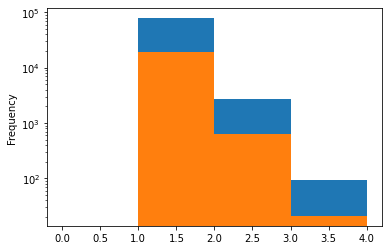

In [33]:
ds_train.depth.plot.hist(bins = list(range(5)))
ds_test.depth.plot.hist(bins = list(range(5)))

plt.yscale('log')

In [35]:
ds_train.loc[ds_train.depth==3].syn_route.iloc[0]

'{C1(C)C=CC(S(O)(=O)=O)=CC=1.C1C=CC=CC=1.[CH2:21]([O:28][CH2:29][CH2:30][CH2:31][OH:32])[C:22]1[CH:27]=[CH:26][CH:25]=[CH:24][CH:23]=1.[NH:1]1[CH2:8][CH2:7][CH2:6][C@H:2]1[C:3]([OH:5])=[O:4].[OH2:33]{C(OCC)(=O)C.C(OCC)(=[O:39])C.[ClH:36]{C(Cl)[Cl:36].[CH3:1][C:2]1[CH:3]=[C:4]([CH:31]=[C:32]([CH3:34])[CH:33]=1)[O:5][C:6]1[CH:11]=[CH:10][C:9]([N+:12]([O-:14])=[O:13])=[CH:8][C:7]=1[S:15]([N:18]1[CH2:23][CH2:22][N:21](C(OC(C)(C)C)=O)[CH2:20][CH2:19]1)(=[O:17])=[O:16].}[S:1]1[C:5]2[CH:6]=[CH:7][CH:8]=[CH:9][C:4]=2[C:3]([N:10]2[CH2:15][CH2:14][N:13]([CH2:16][C@@H:17]3[CH2:22][CH2:21][CH2:20][CH2:19][C@H:18]3[CH2:23][N:24]3[C:32](=[O:33])[C@H:31]4[C@H:26]([C@H:27]5[CH2:34][C@@H:30]4[CH2:29][CH2:28]5)[C:25]3=[O:35])[CH2:12][CH2:11]2)=[N:2]1.}[OH2:9]{C([O:9][C:10]([C:12]1[C:20]2[C:15](=[CH:16][CH:17]=[C:18]([O:21][C:22]3[CH:27]=[CH:26][C:25]([C:28]([F:31])([F:30])[F:29])=[CH:24][CH:23]=3)[CH:19]=2)[N:14]([C:32]2[CH:37]=[CH:36][C:35]([O:38][CH:39]([CH3:41])[CH3:40])=[CH:34][CH:33]=2)[C:13]=1[CH2

In [40]:
'Cl' in ds_train.loc[ds_train.depth==3].syn_route.iloc[0][:2]

False